**Python Code Implementation**

This program demonstrates an example of implementing a mean reversion strategy with the

Johansen Test.

In [2]:
#import libraries
import numpy as np
import pandas as pd
import statsmodels.formula.api as sm
import statsmodels.tsa.stattools as ts
import statsmodels.tsa.vector_ar.vecm as vm
from datetime import datetime
import yfinance as yf


In [105]:
#Create a function to return a dataframe for daily adjusted closing prices

def pull_prices(company_tickers):
    price_data= pd.DataFrame()
    ticker_list= list()    
    
    for i in company_tickers:
        price_data= pd.concat([price_data, 
                                pd.DataFrame(
                                    yf.download(i, start=datetime(2021, 1, 19), 
                                                   end=datetime(2024, 1, 19)
                                               ).iloc[:,4]
                                            )
                               ], axis = 1
                              )
        ticker_list.append(i)        
   
    price_data.columns= ticker_list
    price_data['Date']= price_data.index
    return price_data

In [106]:
#Pull historical prices from 2021 to 2024
tickers= ["QS", "GOEV"] 
df= pull_prices(tickers)

#Check data range
print(df.head())

print(df.tail())

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

                   QS       GOEV       Date
Date                                       
2021-01-19  52.360001  16.680000 2021-01-19
2021-01-20  48.590000  17.360001 2021-01-20
2021-01-21  50.000000  17.120001 2021-01-21
2021-01-22  49.680000  17.000000 2021-01-22
2021-01-25  47.630001  16.799999 2021-01-25
              QS   GOEV       Date
Date                              
2024-01-11  8.10  0.211 2024-01-11
2024-01-12  7.37  0.203 2024-01-12
2024-01-16  6.97  0.185 2024-01-16
2024-01-17  6.65  0.180 2024-01-17
2024-01-18  6.61  0.176 2024-01-18


<Axes: xlabel='Date'>

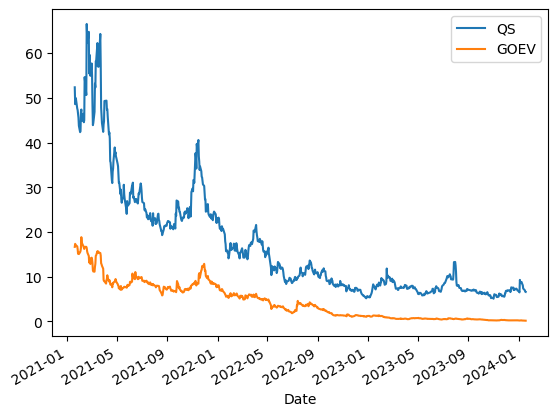

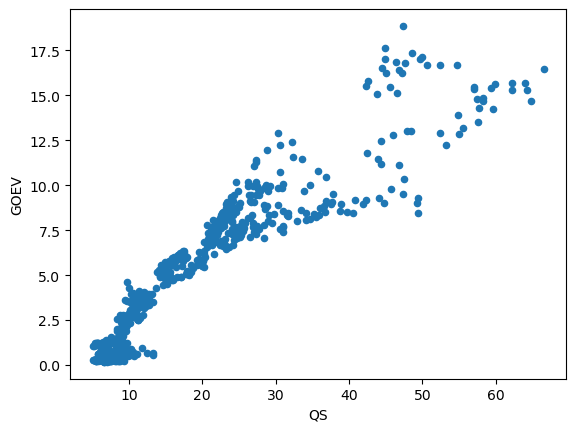

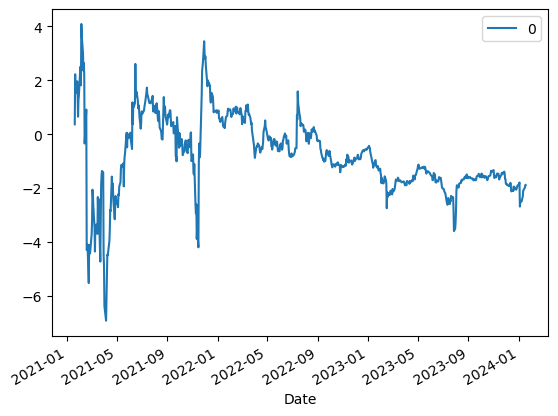

In [107]:
#Generate diagnostic plots
df.set_index('Date', inplace=True)

#Plot daily chart data
df.plot()

#Plot daily price correlation
df.plot.scatter(x='QS', 
                y='GOEV')

#Visualize hedge ratios for cointegration
results= sm.ols(formula="GOEV ~ QS", data=df[['QS', 'GOEV']]).fit()
hedgeRatio= results.params[1]

pd.DataFrame((df['GOEV']-hedgeRatio*df['QS'])).plot()

In [108]:
#Check for stationarity using the CADF test

coint_t, pvalue, crit_value=ts.coint(df['QS'], df['GOEV'])

print('t-statistic=%f' % coint_t)
print('\npvalue=%f' % pvalue)
print('\ncritical values')
print(crit_value)

t-statistic=-2.972421

pvalue=0.116907

critical values
[-3.91102404 -3.34424558 -3.05007972]


In [109]:
#Conduct Johansen Test to generate eigenvalues and eigenvectors
result= vm.coint_johansen(df[['QS', 'GOEV']].values, 
                          det_order=0, k_ar_diff=1
                         )

print('Eigenvalues:')
print(result.eig) 

print('\nEigenvectors:')
print(result.evec) 

Eigenvalues:
[0.020022   0.01042366]

Eigenvectors:
[[ 0.2260519  -0.05411617]
 [-0.69890475 -0.07344132]]


In [110]:
#Calculate the half-life of mean reversion

#Net market value of portfolio
portfolio_value= pd.DataFrame(np.dot(df.values, result.evec[:, 0])) 

#Lag values and differencing
lag= portfolio_value.shift()
differencing= portfolio_value-lag

#Fit a regression
df_regress= pd.concat([lag, differencing], axis=1)
df_regress.columns=['lag', 'differencing']
regression= sm.ols(formula="differencing ~ lag", data=df_regress).fit()

#Calculate Half-Life
half_life= -np.log(2)/regression.params['lag']
print('\nHalf-life to Mean Reversion= %f Days' % half_life)


Half-life to Mean Reversion= 14.452225 Days


APR=0.115786 
Sharpe=0.482382


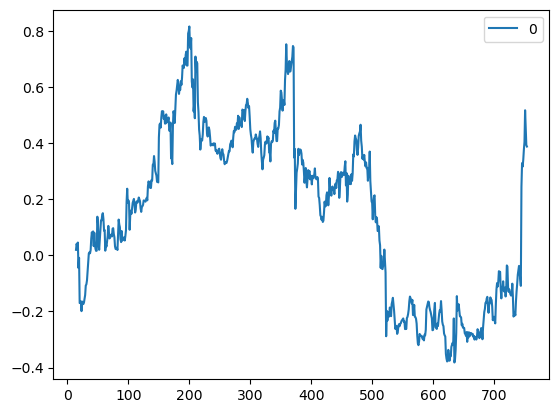

In [114]:
#round
round_half_life= np.round(halflife).astype(int)

#calculate portfolio weightings
portfolio_units = -(portfolio_value-portfolio_value.rolling(round_half_life).mean()
           )/portfolio_value.rolling(round_half_life).std() 

value_of_positions= pd.DataFrame(np.dot(portfolio_units.values, 
                              np.expand_dims(
                                  result.evec[:, 0], 
                                  axis=1).T)*df.values
                      ) 

#Daily P&L
pnl=np.sum((value_of_positions.shift().values)*(df.pct_change().values), axis=1) 

#Returns
returns=pnl/np.sum(np.abs(value_of_positions.shift()), axis=1)

#Plot of Cumulative Returns
pd.DataFrame((np.cumprod(1+ret)-1)).plot()
print('APR=%f \nSharpe=%f' % 
          (np.prod(1+returns)**(252/len(returns))-1, 
           np.sqrt(252)*np.mean(returns)/np.std(returns)
          )
     )